<a href="https://colab.research.google.com/github/AnupamaRajkumar/PyTorchTutorials/blob/main/TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install torch torchvision

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms, models

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

In [4]:
!git clone https://github.com/jaddoescad/ants_and_bees.git

fatal: destination path 'ants_and_bees' already exists and is not an empty directory.


In [5]:
#data augmentation
transform_train = transforms.Compose([transforms.Resize((224, 224)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
                                      transforms.ColorJitter(brightness=1, contrast=1, saturation=1),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                    ])

transform = transforms.Compose([transforms.Resize((224, 224)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])
root_train = 'ants_and_bees/train'
root_val = 'ants_and_bees/val'

training_dataset = datasets.ImageFolder(root=root_train, transform=transform)
validation_dataset = datasets.ImageFolder(root=root_val, transform=transform)

In [6]:
training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=20, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 20, shuffle=False)

In [7]:
print(len(training_dataset))
print(len(validation_dataset))

244
153


In [8]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0) #shape 32 x 32 x 1
  #de-normalisation - multiply by std and add mean
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

classes of ants and bees

In [9]:
classes = ('ant', 'bee')

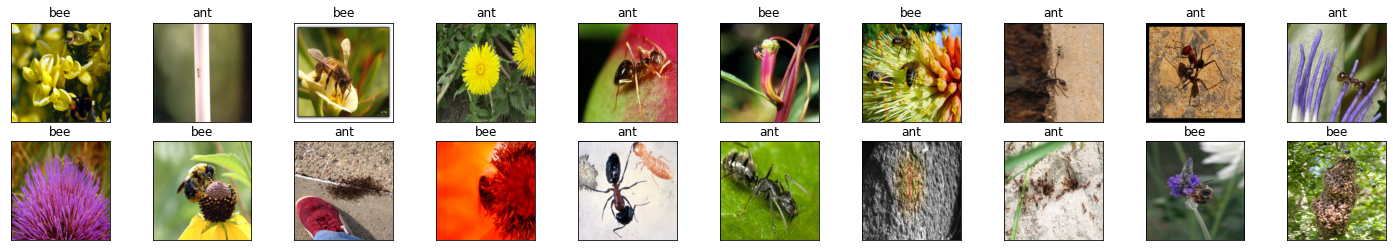

In [10]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25,4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  #print(labels[idx].item())
  ax.set_title(classes[labels[idx].item()])

Using pre-trained AlexNet

In [11]:
model = models.alexnet(pretrained=True)

In [12]:
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

We keep the fully connected layer dynamic and adapt it to our dataset while through transfer learning, we will use the features extracted from the convolutional layers

In [13]:
for param in model.features.parameters():
  param.requires_grad = False         #here we freeze the feature layers             

In [14]:
import torch.nn as nn

#since our model only classifies ants and bees, the output should be 2 instead 
#of 1000 as specified in AlexNet's output layer. Hence, we change the output of 
#6th element of AlexNet classifier

n_inputs = model.classifier[6].in_features      #4096
last_layer = nn.Linear(n_inputs, len(classes))
model.classifier[6] = last_layer
model.to(device)

print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [16]:
epochs = 5
losses = []
accuracy = []
val_losses = []
val_accuracies = []

for e in range(epochs):
  running_loss = 0.0
  running_accuracy = 0.0
  val_loss = 0.0
  val_accuracy = 0.0

  for images, labels in training_loader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)   
    loss = criterion(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    _, preds = torch.max(outputs, 1)
    running_accuracy += torch.sum(preds == labels.data)
    running_loss += loss.item() 

  else:
    with torch.no_grad():       #because we dont have to perform gradients for validation set
      for val_images, val_labels in validation_loader:
        val_images = val_images.to(device)
        val_labels = val_labels.to(device)
        val_outputs = model(val_images)
        val_loss = criterion(val_outputs, val_labels)

        _, val_preds = torch.max(val_outputs, 1)
        val_accuracy += torch.sum(val_preds == val_labels.data)
        val_loss += val_loss.item() 
    #metrics for training data
    epoch_loss = running_loss/len(training_loader.dataset)
    epoch_accuracy = running_accuracy.float()/len(training_loader.dataset)
    losses.append(epoch_loss)
    accuracy.append(epoch_accuracy)
    #metrics for validation data
    val_epoch_loss = val_loss/len(validation_loader.dataset)
    val_epoch_accuracy = val_accuracy.float()/len(validation_loader.dataset)
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_accuracy)
    #print the training and validation metrics
    print("epoch:", e+1)
    print('training loss: {:.6f}, acc {:.6f}'.format(epoch_loss, epoch_accuracy.item()))
    print('validation loss: {:.6f}, acc {:.6f}'.format(val_epoch_loss, val_epoch_accuracy.item()))

epoch: 1
training loss: 0.027200, acc 0.803279
validation loss: 0.008954, acc 0.836601
epoch: 2
training loss: 0.007657, acc 0.954918
validation loss: 0.005246, acc 0.882353
epoch: 3
training loss: 0.004346, acc 0.975410
validation loss: 0.007163, acc 0.875817
epoch: 4
training loss: 0.001558, acc 1.000000
validation loss: 0.007830, acc 0.882353
epoch: 5
training loss: 0.000781, acc 1.000000
validation loss: 0.010340, acc 0.875817


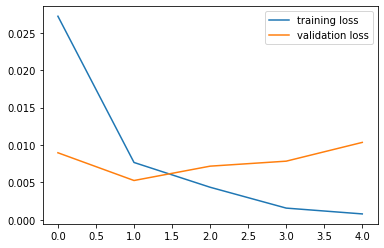

In [17]:
plt.plot(losses, label='training loss')
plt.plot(val_losses, label='validation loss')
plt.legend()

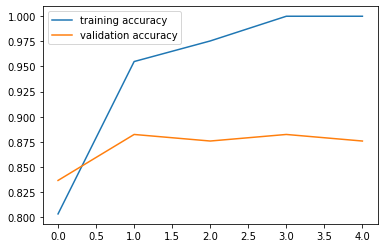

In [18]:
plt.plot(accuracy, label='training accuracy')
plt.plot(val_accuracies, label = 'validation accuracy')
plt.legend()

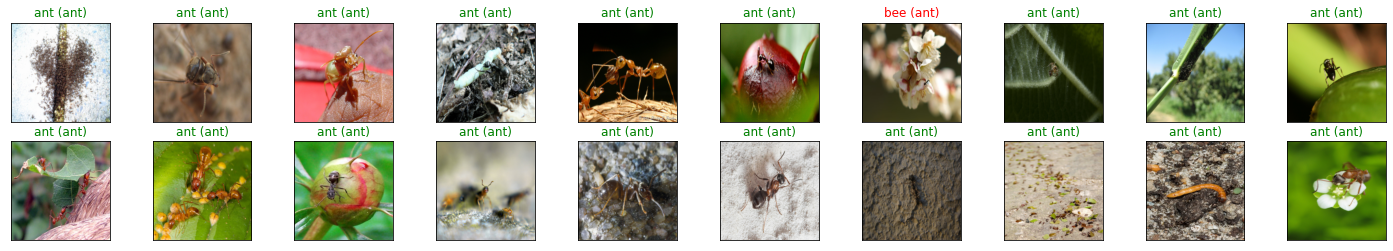

In [19]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color=("green" if preds[idx]==labels[idx] else "red"))